In [1]:
import sys
print(sys.path)
import ROOT
import matplotlib.pyplot as plt
import numpy as np

['/Users/riyakore/Desktop/Astronomy/WIPAC_work', '/Users/riyakore/opt/anaconda3/lib/python39.zip', '/Users/riyakore/opt/anaconda3/lib/python3.9', '/Users/riyakore/opt/anaconda3/lib/python3.9/lib-dynload', '', '/Users/riyakore/.local/lib/python3.9/site-packages', '/Users/riyakore/opt/anaconda3/lib/python3.9/site-packages', '/Users/riyakore/opt/anaconda3/lib/python3.9/site-packages/aeosa']


ModuleNotFoundError: No module named 'ROOT'

<h3>Define datasets</h3>

In [3]:

# The files have a tree called "XCDF"
dataset = {
    "data":{
        "file":"/data/wipac/HAWC/data/pass5/v5.01.00_runs10678-10686.root",
        "norm":1
        
    },
    "mc":{
        "file":"/data/wipac/HAWC/hawcsim/pass5/2.63_3.45e-11_1000000_0_1.0_combined_rec.root",
        "norm":1
    }
}




<h3>Read HAWC Data and MC sets</h3>

In [ ]:


for key, dset in dataset.items():
    
    f = ROOT.TFile.Open(dset["file"],"READONLY")
    t = f.Get("XCDF")
    # Get branch "var1" as numpy array
    dset["zenithAngle"] = t.AsMatrix(["rec.zenithAngle"])
    dset["azimuthAngle"] = t.AsMatrix(["rec.azimuthAngle"])
    dset["nHit"] = t.AsMatrix(["rec.nHit"])
    dset["nChAvail"] = t.AsMatrix(["rec.nChAvail"])
    dset["protonlheEnergy"] = t.AsMatrix(["rec.protonlheEnergy"])
    dset["PINC"] = t.AsMatrix(["rec.PINC"])
    
    dset["CxPE40XnCh"] = t.AsMatrix(["rec.CxPE40XnCh"])
    dset["weights"] = np.ones(dset["protonlheEnergy"].size)
    dset["label"] = "Data"
    dset["cuts"] = np.logical_and(dset["protonlheEnergy"]>=5 , dset["CxPE40XnCh"]>40, dset["nHit"]>=75 )
    dset["LDFAge"] = t.AsMatrix(["rec.LDFAge"])
    dset["angleFitStatus"] = t.AsMatrix(["rec.angleFitStatus"])
    dset["coreFitStatus"] = t.AsMatrix(["rec.coreFitStatus"])
    if key == "mc":
        dset["corsikaParticleId"] = t.AsMatrix(["mc.corsikaParticleId"])
        dset["weights"] = t.AsMatrix(["sweets.IWgt"])
        dset["label"] = "Monte Carlo"
        dset["cuts"] = np.logical_and(dset["cuts"] , dset["corsikaParticleId"]!=1 )
        dset["logEnergy"] = t.AsMatrix(["mc.logEnergy"])
    dset["weights"].shape = dset["protonlheEnergy"].shape
    
    f.Close()
    

<h3>Define cuts</h3>

In [5]:
dataset["data"]["cuts"] = np.logical_and(
    dataset["data"]["protonlheEnergy"]>=5, 
    dataset["data"]["CxPE40XnCh"]>40) 
dataset["data"]["cuts"] = np.logical_and(
    dataset["data"]["cuts"],
    dataset["data"]["nHit"]/dataset["data"]["nChAvail"]>=0.25 )
dataset["data"]["cuts"] = np.logical_and(
    dataset["data"]["cuts"],
    dataset["data"]["zenithAngle"]<70 )

dataset["mc"]["cuts"] = np.logical_and(
    dataset["mc"]["protonlheEnergy"]>=5, 
    dataset["mc"]["CxPE40XnCh"]>40)
dataset["mc"]["cuts"] = np.logical_and(
    dataset["mc"]["cuts"], 
    dataset["mc"]["nHit"]>=75)
dataset["mc"]["cuts"] = np.logical_and(
    dataset["mc"]["cuts"], 
    dataset["mc"]["corsikaParticleId"]!=1 )
dataset["mc"]["cuts"] = np.logical_and(
    dataset["mc"]["cuts"], 
    dataset["mc"]["zenithAngle"]<70 )

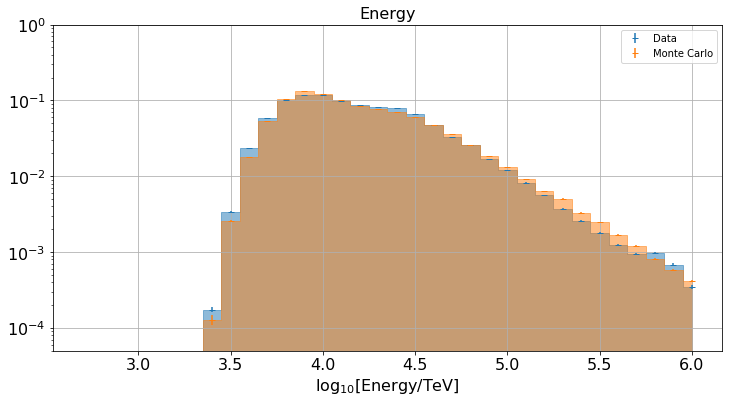

In [6]:
bins = np.logspace(np.log10(3),np.log10(5),80)
bins = np.linspace(2.6,6,35)

fig= plt.figure(figsize=(12,6))
ax = plt.subplot(111)
norm = 1

weights = dataset["data"]["weights"]
energy = dataset["data"]["protonlheEnergy"]-9
cuts = dataset["data"]["cuts"]
                               
hn, hbins = np.histogram(energy[cuts], bins=bins, weights=weights[cuts])
norm = hn.sum()

# calculate the errors: sqrt(\sum w^2)
en, ebins = np.histogram(energy[cuts], bins=bins, weights=np.power(weights[cuts],2))  
tm = plt.errorbar(ebins[1:],hn/norm, yerr=np.sqrt(en)/norm,fmt="_", label="Data")
color = tm[0].get_color()
ax.fill_between(ebins[1:], 5e-5, hn/norm, step='mid', color=color,alpha=0.5)


weights = dataset["mc"]["weights"]
energy = dataset["mc"]["protonlheEnergy"]-9
cuts = dataset["mc"]["cuts"]


hn, hbins = np.histogram(energy[cuts]+0.5, bins=bins, weights=weights[cuts])
norm = hn.sum()


# calculate the errors: sqrt(\sum w^2)
en, ebins = np.histogram(energy[cuts]+0.5, bins=bins, weights=np.power(weights[cuts],2))  
tm = plt.errorbar(ebins[1:],hn/norm, yerr=np.sqrt(en)/norm,fmt="_", label="Monte Carlo")
color = tm[0].get_color()
ax.fill_between(ebins[1:], 5e-5, hn/norm, step='mid', color=color,alpha=0.5)

ax.grid()

plt.xlabel('$\log_{10}$[Energy/TeV]', fontsize=16)
plt.title('Energy', fontsize=16)
plt.yscale("log")

plt.legend()
plt.ylim(5e-5,1)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)
        
fig.savefig("energy.pdf", dpi=100)
plt.show()

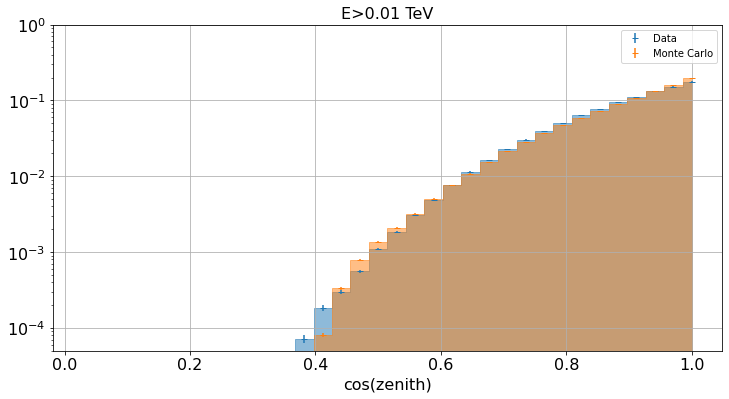

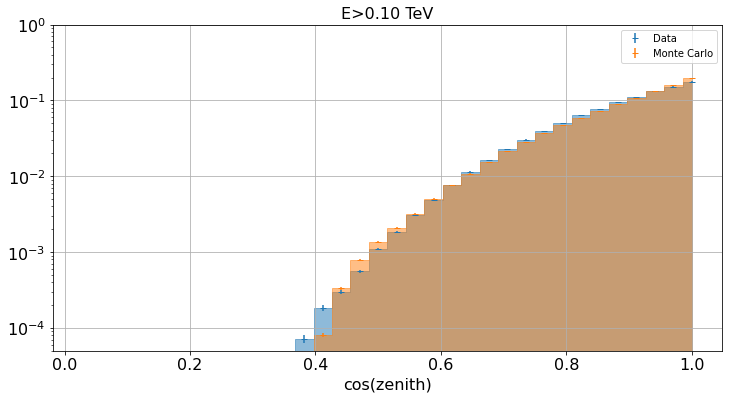

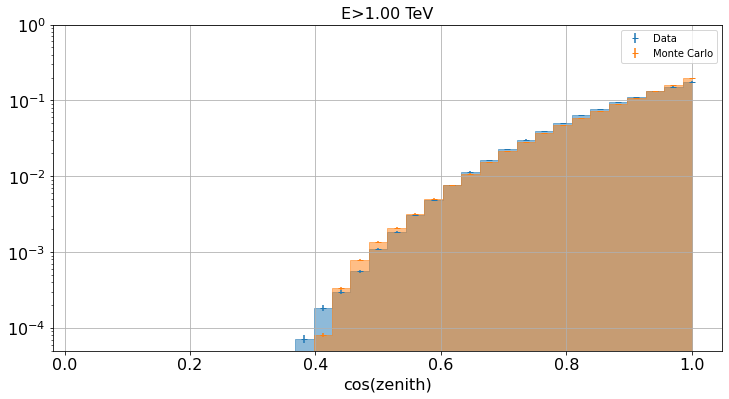

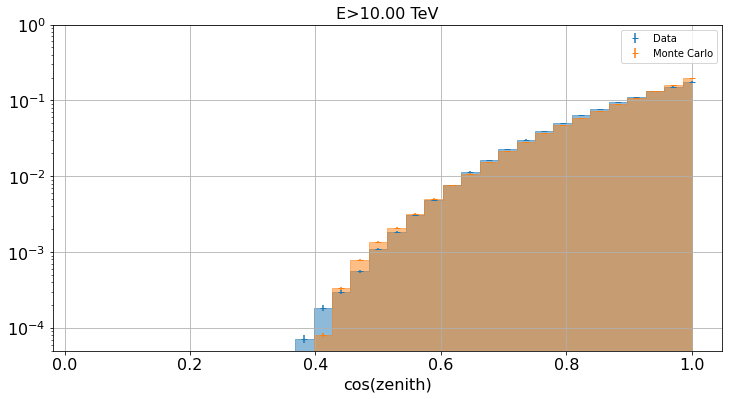

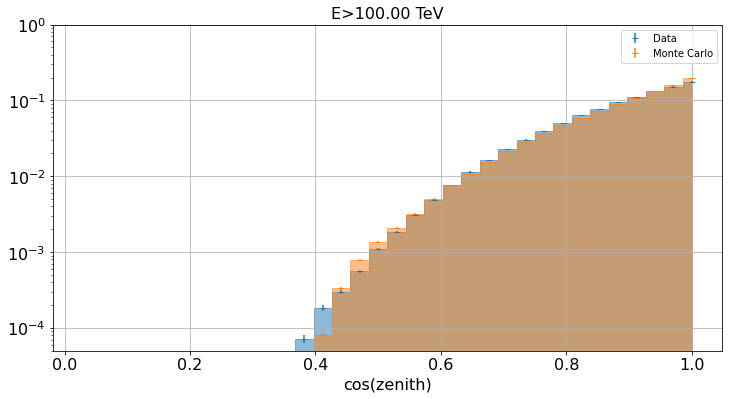

In [456]:
cos=True
bins = np.linspace(0,80,35)
func = lambda x:np.degrees(x)
xlabel = "zenith [deg]"
if cos:
    bins = np.linspace(0,1,35)
    func = lambda x: np.cos(x)
    xlabel = "cos(zenith)"
for ecut in [7,8,9,10,11]:
    fig= plt.figure(figsize=(12,6))
    ax = plt.subplot(111)
    norm = 1
    energy = dataset["data"]["protonlheEnergy"]
    weights = dataset["data"]["weights"]
    zenith = dataset["data"]["zenithAngle"]
    cuts = np.logical_and(energy>=ecut, zenith < np.radians(70))
    cuts = np.logical_and(cuts, dataset["data"]["cuts"])

    hn, hbins = np.histogram(func(zenith[cuts]), bins=bins, weights=weights[cuts])
    norm = hn.sum()
    # calculate the errors: sqrt(\sum w^2)

    en, ebins = np.histogram(func(zenith[cuts]), bins=bins, weights=np.power(weights[cuts],2))  
    tm = plt.errorbar(ebins[1:],hn/norm, yerr=np.sqrt(en)/norm,fmt="_", label="Data")
    color = tm[0].get_color()
    ax.fill_between(ebins[1:], 5e-5, hn/norm, step='mid', color=color,alpha=0.5)

    
    energy = dataset["mc"]["protonlheEnergy"]+.5
    zenith = dataset["mc"]["zenithAngle"]
    weights = dataset["mc"]["weights"]
    
    cuts = np.logical_and(energy>=ecut, zenith < np.radians(70))
    cuts = np.logical_and(cuts, dataset["mc"]["cuts"])


    hn, hbins = np.histogram(func(zenith[cuts]), bins=bins, weights=weights[cuts])
    norm = hn.sum()
    # calculate the errors: sqrt(\sum w^2)
    en, ebins = np.histogram(func(zenith[cuts]), bins=bins, weights=np.power(weights[cuts],2))  
    tm = plt.errorbar(ebins[1:],hn/norm, yerr=np.sqrt(en)/norm,fmt="_", label="Monte Carlo")
    color = tm[0].get_color()
    ax.fill_between(ebins[1:], 5e-5, hn/norm, step='mid', color=color,alpha=0.5)

    #plt.plot(hbins[1:],hn)
    ax.grid()

    plt.xlabel(xlabel, fontsize=16)
    #plt.ylabel("Energy", fontsize=16)
    plt.title('E>%0.2f TeV'%np.power(10.,(ecut-9)), fontsize=16)
    #plt.xscale("log")
    plt.yscale("log")

    plt.legend()
    plt.ylim(5e-5,1)
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(16)
    if cos:
        fig.savefig("cos_zenith-{:0.2f}.pdf".format(ecut-9), dpi=100)
    else:
        fig.savefig("zenith-{:0.2f}.pdf".format(ecut-9), dpi=100)
    plt.show()

dE offset 0.10000000000000009


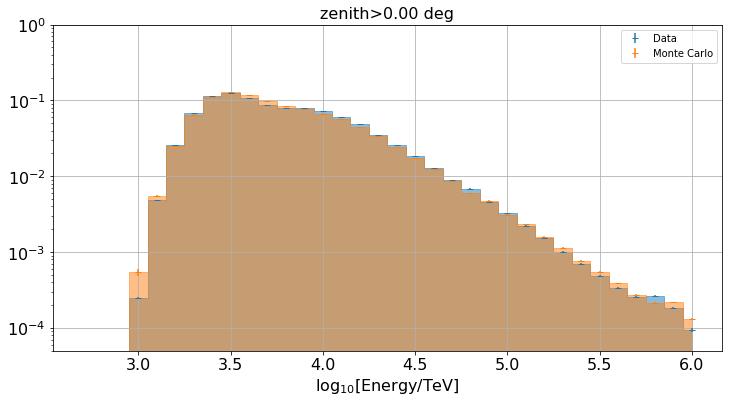

dE offset 0.10000000000000009


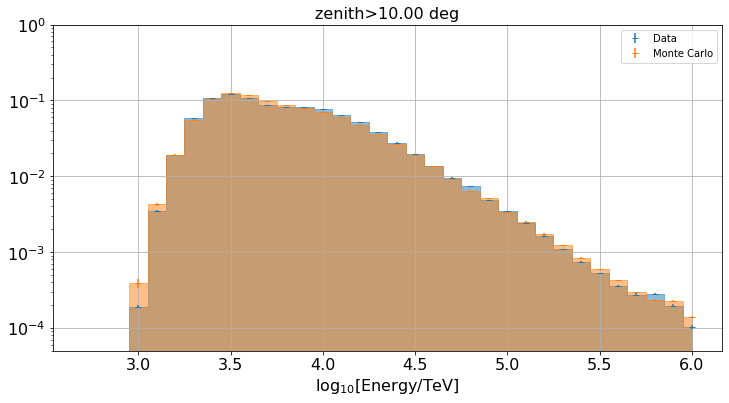

dE offset 0.10000000000000009


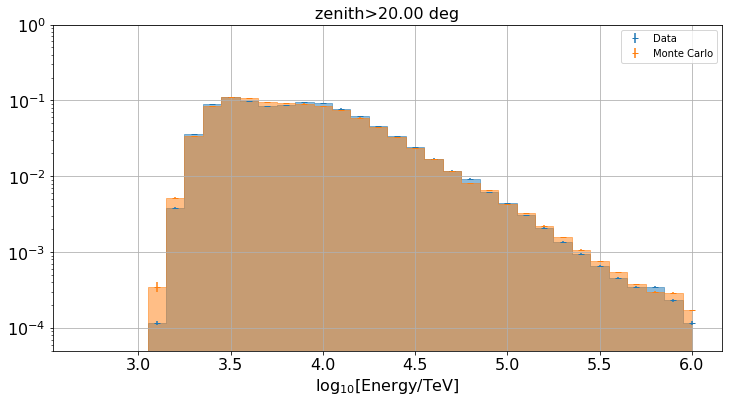

dE offset 0.10000000000000009


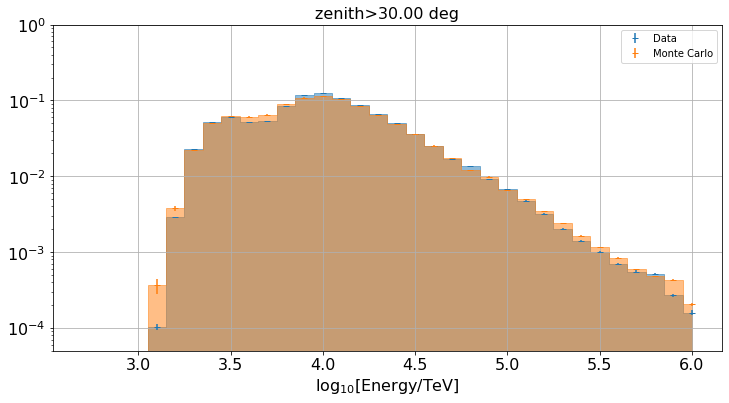

dE offset 0.10000000000000009


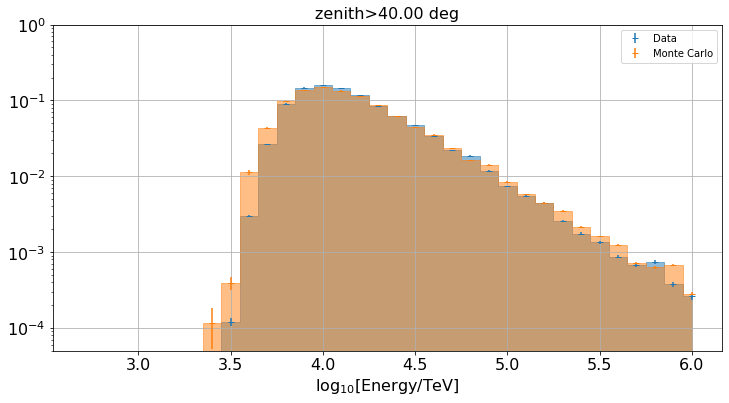

dE offset 0.10000000000000009


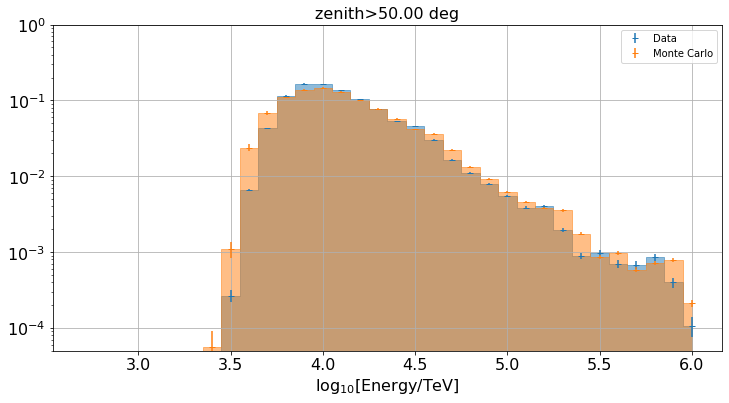

dE offset 0.10000000000000009


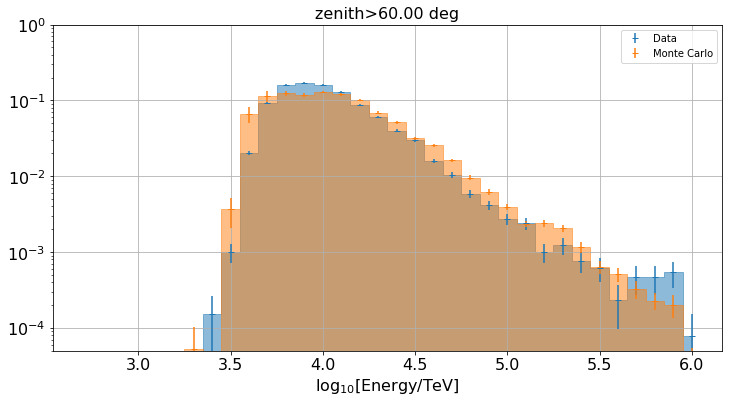

[[3.75]
 [3.85]
 [3.15]
 [4.85]
 [3.95]
 [3.75]
 [3.35]
 [3.25]
 [4.45]
 [4.95]]


In [405]:
cos=True
bins = np.linspace(2.6,6,35)
func = lambda x:np.degrees(x)
xlabel = "Energ [deg]"

for zcut in [0,10,20,30,40,50,60]:
    fig= plt.figure(figsize=(12,6))
    ax = plt.subplot(111)
    norm = 1
    energy = dataset["data"]["protonlheEnergy"]-9
    weights = dataset["data"]["weights"]
    zenith = dataset["data"]["zenithAngle"]
    dE = (bins[1]-bins[0])
    print("dE offset",dE)
    cuts = np.logical_and(zenith>=np.radians(zcut), dataset["data"]["cuts"])

    hn, hbins = np.histogram(energy[cuts], bins=bins, weights=weights[cuts])
    norm = hn.sum()
    # calculate the errors: sqrt(\sum w^2)

    en, ebins = np.histogram(energy[cuts], bins=bins, weights=np.power(weights[cuts],2))  
    tm = plt.errorbar(ebins[1:],hn/norm, yerr=np.sqrt(en)/norm,fmt="_", label="Data")
    color = tm[0].get_color()
    ax.fill_between(ebins[1:], 5e-5, hn/norm, step='mid', color=color,alpha=0.5)

    
    energy = dataset["mc"]["protonlheEnergy"]-9
    zenith = dataset["mc"]["zenithAngle"]
    weights = dataset["mc"]["weights"]
    cuts = np.logical_and(zenith>=np.radians(zcut), dataset["mc"]["cuts"])

    hn, hbins = np.histogram(energy[cuts]+dE, bins=bins, weights=weights[cuts])
    norm = hn.sum()
    # calculate the errors: sqrt(\sum w^2)
    en, ebins = np.histogram(energy[cuts]+dE, bins=bins, weights=np.power(weights[cuts],2))  
    tm = plt.errorbar(ebins[1:],hn/norm, yerr=np.sqrt(en)/norm,fmt="_", label="Monte Carlo")
    color = tm[0].get_color()
    ax.fill_between(ebins[1:], 5e-5, hn/norm, step='mid', color=color,alpha=0.5)

    #plt.plot(hbins[1:],hn)
    ax.grid()
    plt.xlabel('$\log_{10}$[Energy/TeV]', fontsize=16)
    #plt.ylabel("Energy", fontsize=16)
    plt.title('zenith>%0.2f deg'%zcut, fontsize=16)
    #plt.xscale("log")
    plt.yscale("log")

    plt.legend()
    plt.ylim(5e-5,1)
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(16)

    fig.savefig("energy-zenGT{:0.2f}deg.pdf".format(zcut), dpi=100)
    plt.show()
print(energy[:10])

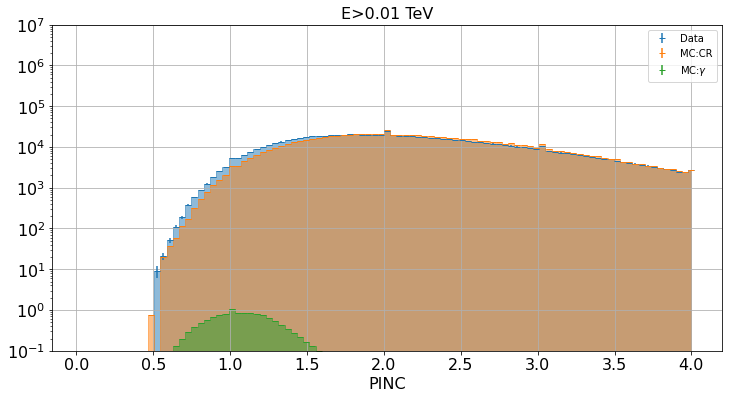

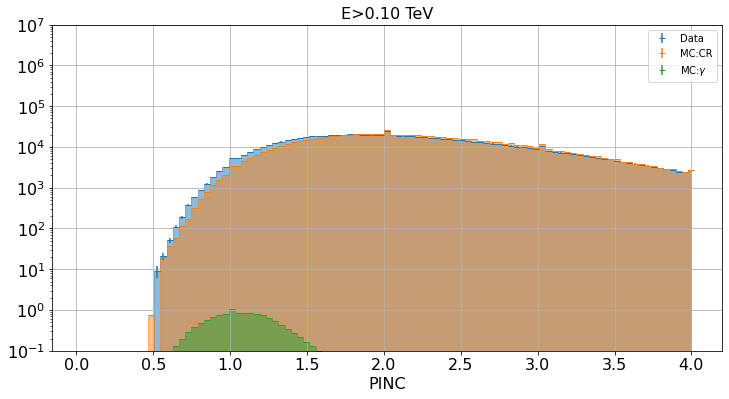

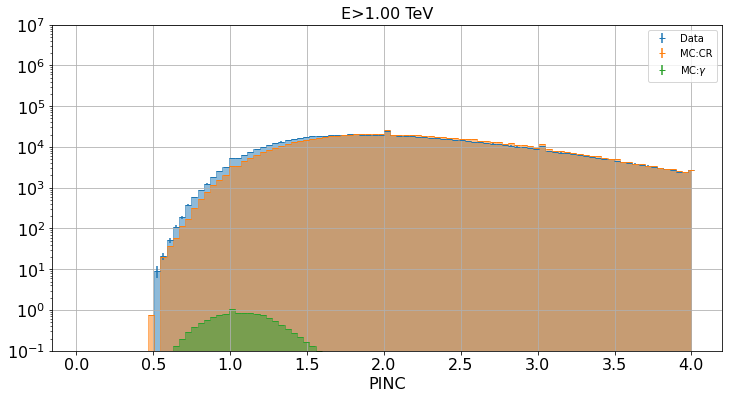

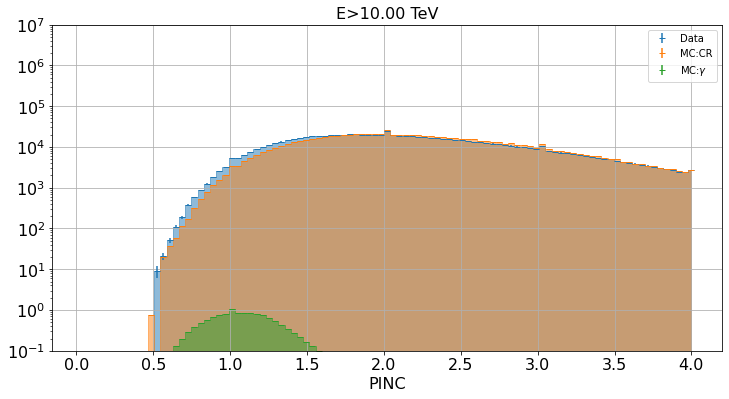

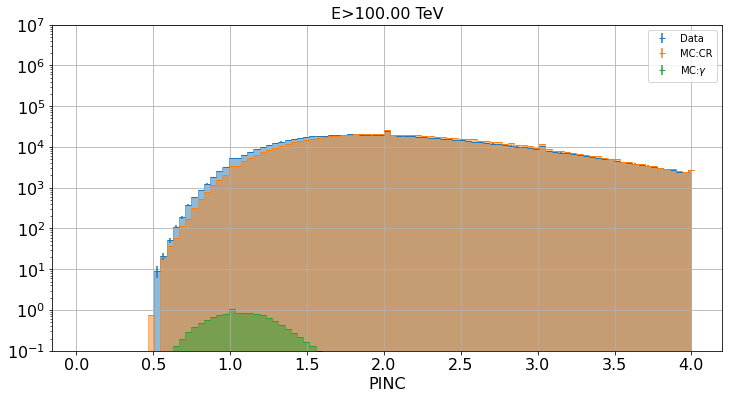

In [467]:
cos=True
bins = 100
bins = np.logspace(np.log10(1e-1),np.log10(14),80)
bins = np.linspace(0,4,100)


xlabel = "PINC"

for ecut in [7,8,9,10,11]:
    fig= plt.figure(figsize=(12,6))
    ax = plt.subplot(111)
    norm = 1
    energy = dataset["data"]["protonlheEnergy"]
    weights = dataset["data"]["weights"]
    zenith = dataset["data"]["zenithAngle"]
    pinc = dataset["data"]["PINC"]
    cxpe40x = dataset["data"]["CxPE40XnCh"]


    fhit = dataset["data"]["nHit"]/dataset["data"]["nChAvail"]
    cuts = np.logical_and(zenith < np.radians(70),zenith > 0)
    cuts = np.logical_and(energy>=ecut, cuts)
    cuts = np.logical_and(cuts, energy>=5) 
    cuts = np.logical_and(cuts, cxpe40x>40)
    cuts = np.logical_and(cuts, fhit>=0.25)
    
    hn, hbins = np.histogram(pinc[cuts], bins=bins, weights=weights[cuts])
    data_norm = hn.sum()
    # calculate the errors: sqrt(\sum w^2)

    en, ebins = np.histogram(pinc[cuts], bins=bins, weights=np.power(weights[cuts],2))  
    tm = plt.errorbar(ebins[1:],hn, yerr=np.sqrt(en)/norm,fmt="_", label="Data")
    color = tm[0].get_color()
    ax.fill_between(ebins[1:], 1e-6, hn, step='mid', color=color,alpha=0.5)

    fhit = dataset["mc"]["nHit"]/dataset["mc"]["nChAvail"]
    energy = dataset["mc"]["protonlheEnergy"]+.55
    zenith = dataset["mc"]["zenithAngle"]
    weights = dataset["mc"]["weights"]
    pinc = dataset["mc"]["PINC"]
    cxpe40x = dataset["mc"]["CxPE40XnCh"]


    
    cuts = np.logical_and(zenith < np.radians(70),zenith > 0)
    cuts = np.logical_and(energy>=ecut, cuts)
    cuts = np.logical_and(cuts, dataset["mc"]["corsikaParticleId"]!=1 )
    cuts = np.logical_and(cuts, energy>=5) 
    cuts = np.logical_and(cuts, cxpe40x>40)
    cuts = np.logical_and(cuts, fhit>=0.25)


    hn, hbins = np.histogram(pinc[cuts], bins=bins, weights=weights[cuts])
    mc_norm = hn.sum()/data_norm
    
    # calculate the errors: sqrt(\sum w^2)
    en, ebins = np.histogram(pinc[cuts], bins=bins, weights=np.power(weights[cuts],2))  
    tm = plt.errorbar(ebins[1:],hn/mc_norm, yerr=np.sqrt(en)/norm,fmt="_", label="MC:CR")
    color = tm[0].get_color()
    ax.fill_between(ebins[1:], 1e-6, hn/mc_norm, step='mid', color=color,alpha=0.5)
    
    #Select Gammas
    cuts = np.logical_and(zenith < np.radians(70),zenith > 0)
    cuts = np.logical_and(energy>=ecut, cuts)
    cuts = np.logical_and(cuts, dataset["mc"]["corsikaParticleId"]==1 )
    cuts = np.logical_and(cuts, energy>=5) 
    cuts = np.logical_and(cuts, cxpe40x>40)
    cuts = np.logical_and(cuts, fhit>=0.25)
    
    hn, hbins = np.histogram(pinc[cuts], bins=bins, weights=weights[cuts])
    norm = hn.sum()
    
    # calculate the errors: sqrt(\sum w^2)
    en, ebins = np.histogram(pinc[cuts], bins=bins, weights=np.power(weights[cuts],2))  
    tm = plt.errorbar(ebins[1:],hn/mc_norm, yerr=np.sqrt(en)/norm,fmt="_", label="MC:$\gamma$")
    color = tm[0].get_color()
    ax.fill_between(ebins[1:], 1e-6, hn/mc_norm, step='mid', color=color,alpha=0.5)

    ax.grid()

    plt.xlabel(xlabel, fontsize=16)
    plt.title('E>%0.2f TeV'%np.power(10.,(ecut-9)), fontsize=16)
    plt.yscale("log")

    plt.legend()
    plt.ylim(1e-1,1e7)
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(16)

    fig.savefig("pinc-{:0.2f}.pdf".format(ecut-9), dpi=100)
    plt.show()

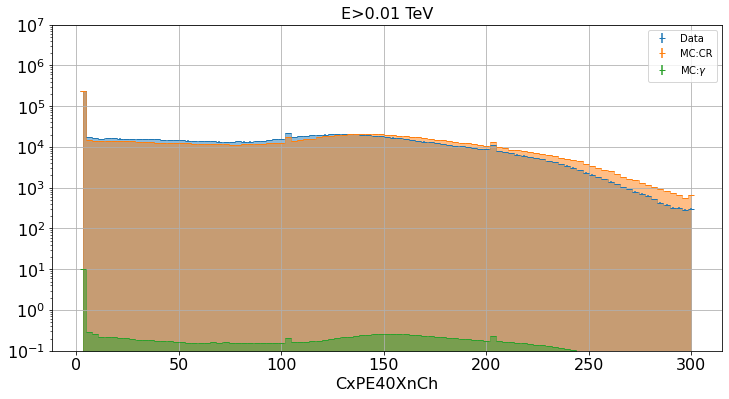

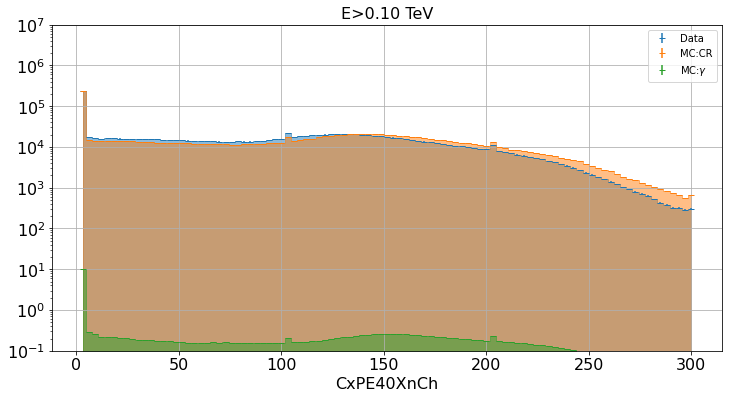

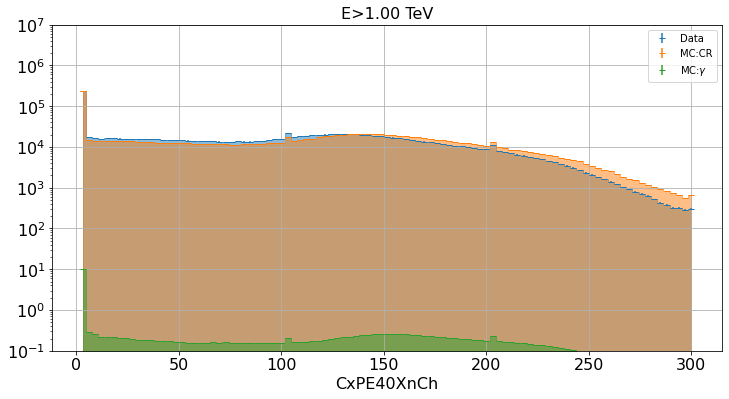

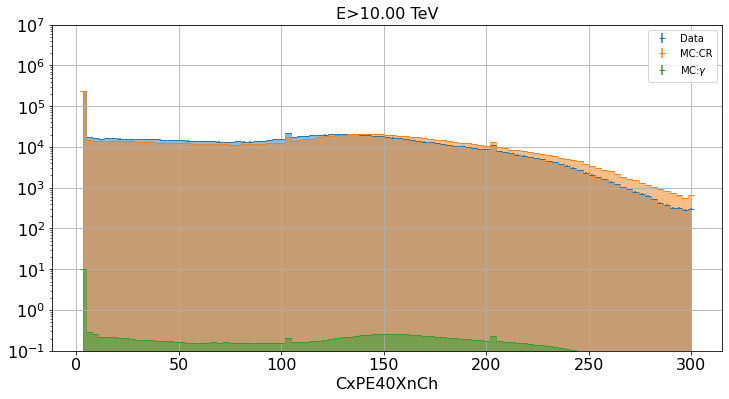

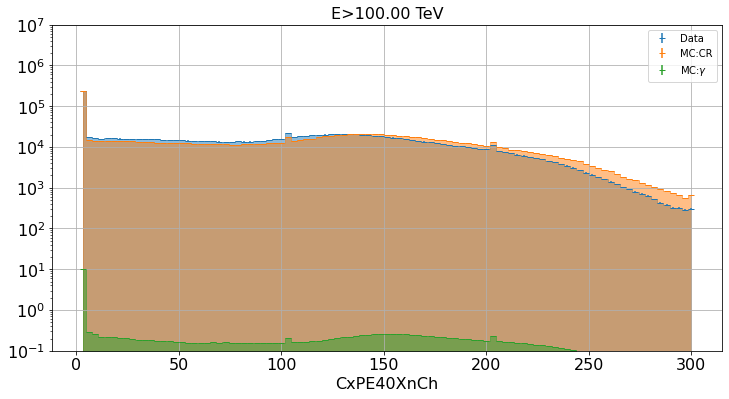

In [470]:

cos=True
bins = 100
bins = np.logspace(np.log10(1e-1),np.log10(15),80)
bins = np.linspace(0,300,100)


xlabel = "CxPE40XnCh"

for ecut in [7,8,9,10,11]:
    fig= plt.figure(figsize=(12,6))
    ax = plt.subplot(111)
    norm = 1
    fhit = dataset["data"]["nHit"]/dataset["data"]["nChAvail"]
    energy = dataset["data"]["protonlheEnergy"]
    weights = dataset["data"]["weights"]
    zenith = dataset["data"]["zenithAngle"]
    pinc = dataset["data"]["PINC"]
    cxpe40x = dataset["data"]["CxPE40XnCh"]

    #cuts = np.logical_and(energy>=ecut, zenith < np.radians(70))
    #cuts = np.logical_and(cuts, dataset["data"]["cuts"])

    cuts = np.logical_and(zenith < np.radians(70),zenith > 0)
    cuts = np.logical_and(energy>=ecut, cuts)
    cuts = np.logical_and(cuts, energy>=5) 
    cuts = np.logical_and(cuts, fhit>=0.25)
    
    hn, hbins = np.histogram(cxpe40x[cuts], bins=bins, weights=weights[cuts])
    data_norm = hn.sum()
    # calculate the errors: sqrt(\sum w^2)

    en, ebins = np.histogram(cxpe40x[cuts], bins=bins, weights=np.power(weights[cuts],2))  
    tm = plt.errorbar(ebins[1:],hn, yerr=np.sqrt(en)/norm,fmt="_", label="Data")
    color = tm[0].get_color()
    ax.fill_between(ebins[1:], 1e-6, hn, step='mid', color=color,alpha=0.5)

    fhit = dataset["mc"]["nHit"]/dataset["mc"]["nChAvail"]
    energy = dataset["mc"]["protonlheEnergy"]+.055
    zenith = dataset["mc"]["zenithAngle"]
    weights = dataset["mc"]["weights"]
    pinc = dataset["mc"]["PINC"]
    cxpe40x = dataset["mc"]["CxPE40XnCh"]


    cuts = np.logical_and(zenith < np.radians(70),zenith > 0)
    cuts = np.logical_and(energy>=ecut, cuts)
    cuts = np.logical_and(cuts, energy>=5) 
    cuts = np.logical_and(cuts, fhit>=0.25)


    hn, hbins = np.histogram(cxpe40x[cuts], bins=bins, weights=weights[cuts])
    mc_norm = hn.sum()/data_norm
    
    # calculate the errors: sqrt(\sum w^2)
    en, ebins = np.histogram(cxpe40x[cuts], bins=bins, weights=np.power(weights[cuts],2))  
    tm = plt.errorbar(ebins[1:],hn/mc_norm, yerr=np.sqrt(en)/norm,fmt="_", label="MC:CR")
    color = tm[0].get_color()
    ax.fill_between(ebins[1:], 1e-6, hn/mc_norm, step='mid', color=color,alpha=0.5)
    
    #Gammas
    cuts = np.logical_and(zenith < np.radians(70),zenith > 0)
    cuts = np.logical_and(energy>=ecut, cuts)
    cuts = np.logical_and(cuts, dataset["mc"]["corsikaParticleId"]==1 )
    cuts = np.logical_and(cuts, energy>=5) 
    cuts = np.logical_and(cuts, fhit>=0.25)
    
    hn, hbins = np.histogram(cxpe40x[cuts], bins=bins, weights=weights[cuts])
    norm = hn.sum()
    
    # calculate the errors: sqrt(\sum w^2)
    en, ebins = np.histogram(cxpe40x[cuts], bins=bins, weights=np.power(weights[cuts],2))  
    tm = plt.errorbar(ebins[1:],hn/mc_norm, yerr=np.sqrt(en)/norm,fmt="_", label="MC:$\gamma$")
    color = tm[0].get_color()
    ax.fill_between(ebins[1:], 1e-6, hn/mc_norm, step='mid', color=color,alpha=0.5)

    #plt.plot(hbins[1:],hn)
    ax.grid()

    plt.xlabel(xlabel, fontsize=16)
    #plt.ylabel("Energy", fontsize=16)
    plt.title('E>%0.2f TeV'%np.power(10.,(ecut-9)), fontsize=16)
    #plt.xscale("log")
    plt.yscale("log")
    #plt.xscale("log")

    plt.legend()
    plt.ylim(1e-1,1e7)
    #plt.xlim(1e-1,20)
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(16)

    fig.savefig("CxPE40XnCh-{:0.2f}.pdf".format(ecut-9), dpi=100)
    plt.show()

No handles with labels found to put in legend.


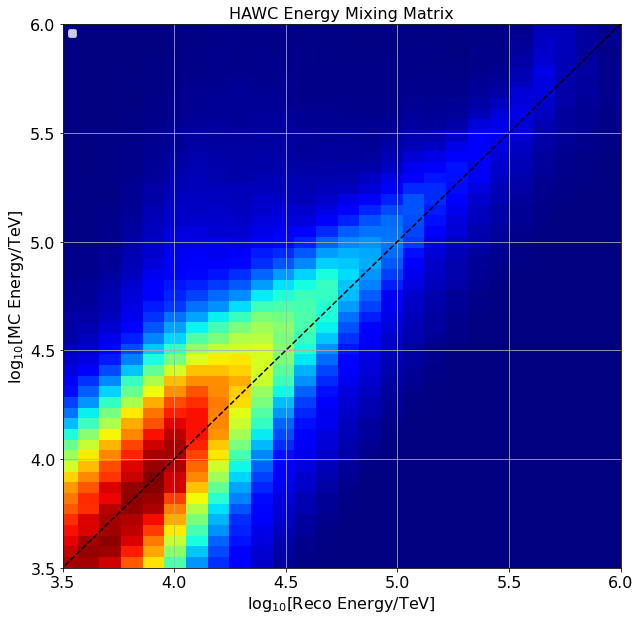

In [25]:
fig= plt.figure(figsize=(10,10))
ax = plt.subplot(111)

energy = dataset["mc"]["protonlheEnergy"]-9.055
zenith = dataset["mc"]["zenithAngle"]
weights = dataset["mc"]["weights"]
pinc = dataset["mc"]["PINC"]
cxpe40x = dataset["mc"]["CxPE40XnCh"]
mcenergy = dataset["mc"]["logEnergy"]#-9

cuts = np.logical_and(zenith < np.radians(70),zenith > 0)
cuts = np.logical_and(cuts, dataset["mc"]["corsikaParticleId"]!=1 )
#cuts = np.logical_and(cuts, energy>=5) 
cuts = np.logical_and(cuts, cxpe40x>40)
#cuts = np.logical_and(cuts, dataset["mc"]["nHit"]>=75)
plt.hist2d(energy[cuts], mcenergy[cuts], bins=(35, 100), cmap=plt.cm.jet)
plt.plot([2.8,6],[2.8,6],'--',color="black")

ax.grid()

plt.xlabel("$\log_{10}$[Reco Energy/TeV]", fontsize=16)
plt.ylabel("$\log_{10}$[MC Energy/TeV]", fontsize=16)
plt.title('HAWC Energy Mixing Matrix', fontsize=16)


plt.legend()
plt.ylim(3.5,6)
plt.xlim(3.5,6)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

fig.savefig("energy_resol_hawc.pdf", dpi=100)
plt.show()

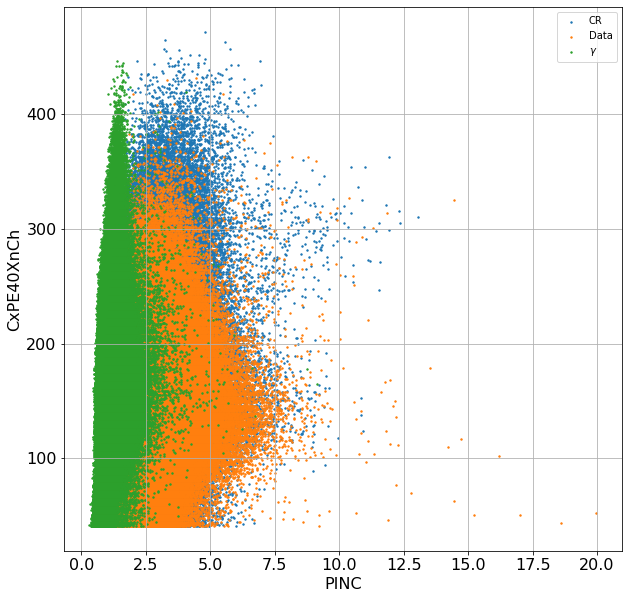

In [472]:
fig= plt.figure(figsize=(10,10))
ax = plt.subplot(111)

fhit = dataset["mc"]["nHit"]/dataset["mc"]["nChAvail"]
energy = dataset["mc"]["protonlheEnergy"]-9.055
zenith = dataset["mc"]["zenithAngle"]
weights = dataset["mc"]["weights"]
pinc = dataset["mc"]["PINC"]
cxpe40x = dataset["mc"]["CxPE40XnCh"]
mcenergy = dataset["mc"]["logEnergy"]#-9
nhit = dataset["mc"]["nHit"]


cuts = np.logical_and(zenith < np.radians(70),zenith > 0)
cuts = np.logical_and(cuts, energy>=3) 
cuts = np.logical_and(cuts, cxpe40x>40)
cuts = np.logical_and(cuts, fhit>=0.25)
cutscr = np.logical_and(cuts, dataset["mc"]["corsikaParticleId"]!=1 )
plt.scatter(pinc[cutscr], cxpe40x[cutscr], s=2,label="CR")

fhit = dataset["data"]["nHit"]/dataset["data"]["nChAvail"]
energy = dataset["data"]["protonlheEnergy"]-9.055
zenith = dataset["data"]["zenithAngle"]
weights = dataset["data"]["weights"]
pinc = dataset["data"]["PINC"]
cxpe40x = dataset["data"]["CxPE40XnCh"]
nhit = dataset["data"]["nHit"]

cuts = np.logical_and(zenith < np.radians(70),zenith > 0)
cuts = np.logical_and(cuts, energy>=3) 
cuts = np.logical_and(cuts, cxpe40x>40)
cuts = np.logical_and(cuts, fhit>=0.25)
plt.scatter(pinc[cuts], cxpe40x[cuts],s=2,label="Data")

fhit = dataset["mc"]["nHit"]/dataset["mc"]["nChAvail"]
energy = dataset["mc"]["protonlheEnergy"]-9.055
zenith = dataset["mc"]["zenithAngle"]
weights = dataset["mc"]["weights"]
pinc = dataset["mc"]["PINC"]
cxpe40x = dataset["mc"]["CxPE40XnCh"]
mcenergy = dataset["mc"]["logEnergy"]#-9
nhit = dataset["mc"]["nHit"]


cuts = np.logical_and(zenith < np.radians(70),zenith > 0)
cuts = np.logical_and(cuts, energy>=3) 
cuts = np.logical_and(cuts, cxpe40x>40)
cuts = np.logical_and(cuts, fhit>=0.25)
cutscr = np.logical_and(cuts, dataset["mc"]["corsikaParticleId"]!=1 )
cutsgamma = np.logical_and(cuts, dataset["mc"]["corsikaParticleId"]==1 )
plt.scatter(pinc[cutsgamma], cxpe40x[cutsgamma], s=2,label="$\gamma$")


ax.grid()

plt.xlabel("PINC", fontsize=16)
plt.ylabel("CxPE40XnCh", fontsize=16)
#plt.title('Energy', fontsize=16)
#plt.xscale("log")
#plt.yscale("log")

plt.legend()
#plt.ylim(3.5,6)
#plt.xlim(3.5,6)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

#fig.savefig("energy_resol.pdf".format(ecut-9), dpi=100)
plt.show()

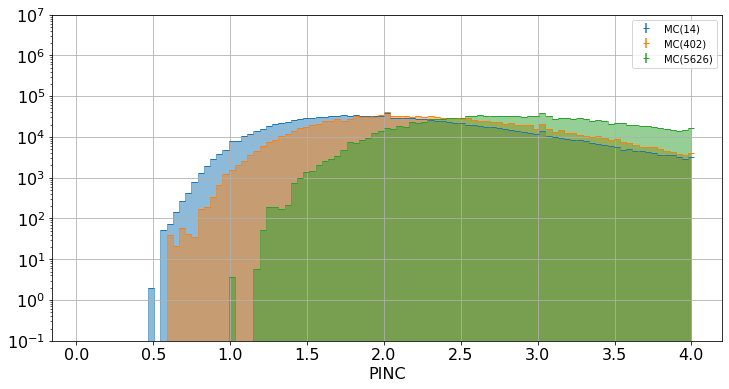

In [473]:


bins = 100
bins = np.logspace(np.log10(1e-1),np.log10(15),80)
bins = np.linspace(0,4,100)
emin = 3

xlabel = "PINC"
fig= plt.figure(figsize=(12,6))
ax = plt.subplot(111)
#for p in sorted(ptypes):
for p in [14,402,5626]:
    norm = 1

    fhit = dataset["mc"]["nHit"]/dataset["mc"]["nChAvail"]
    energy = dataset["mc"]["protonlheEnergy"]+.055
    zenith = dataset["mc"]["zenithAngle"]
    weights = dataset["mc"]["weights"]
    pinc = dataset["mc"]["PINC"]
    cxpe40x = dataset["mc"]["CxPE40XnCh"]
 
    cuts = np.logical_and(zenith < np.radians(70),zenith > 0)
    cuts = np.logical_and(cuts, dataset["mc"]["corsikaParticleId"]==p )
    cuts = np.logical_and(cuts, energy>=emin) 
    cuts = np.logical_and(cuts, cxpe40x>40)
    cuts = np.logical_and(cuts, fhit>=0.25)


    hn, hbins = np.histogram(pinc[cuts], bins=bins, weights=weights[cuts])
    mc_norm = hn.sum()/data_norm
    # calculate the errors: sqrt(\sum w^2)
    en, ebins = np.histogram(pinc[cuts], bins=bins, weights=np.power(weights[cuts],2))  
    tm = plt.errorbar(ebins[1:],hn/mc_norm, yerr=np.sqrt(en)/norm,fmt="_", label="MC(%s)"%p)
    color = tm[0].get_color()
    ax.fill_between(ebins[1:], 1e-6, hn/mc_norm, step='mid', color=color,alpha=0.5)
       

ax.grid()

plt.xlabel(xlabel, fontsize=16)
plt.yscale("log")

plt.legend()
plt.ylim(1e-1,1e7)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
     item.set_fontsize(16)

fig.savefig("pincCRType.pdf", dpi=100)
plt.show()

In [14]:
"""
Weighted quantile
Taken from Stack Overflow: @Alleo
https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy
"""

def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ 
    Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!

    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.

    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

E_med=3.96 (-1.8, +8.97)
E_med=10.1 (-4.05, +25.2)
E_med=38.4 (-15.6, +76)
E_med=100 (-43, +242)
E_med=59.7 (-24.7, +130)


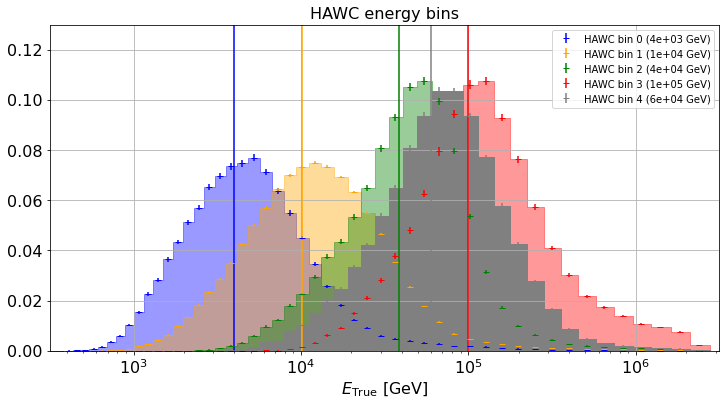

In [182]:
import scipy as sp
import scipy.stats 
from scipy.stats import norm as scinorm
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

#bins = 100
bins = np.logspace(np.log10(1.8),np.log10(6.5),70)
energy_bins = [[3.0,3.86], [3.8,4.699], [4.699, 5], [5,100], [4.8,5.6]]



"""
Energy bins for IceCube-HAWC combined analysis
0  (rec.protonlheEnergy-9 >= 3.0) && (rec.protonlheEnergy-9<3.86) 
1  (rec.protonlheEnergy-9 >= 3.86) && (rec.protonlheEnergy-9 < 4.699) 
2  (rec.protonlheEnergy-9 >= 4.699) && (rec.protonlheEnergy-9 < 5)
3  (rec.protonlheEnergy-9 >=5) "
"""
xlabel = r'$E_\mathrm{True}$ [GeV]'
fig= plt.figure(figsize=(12,6))
ax = plt.subplot(111)
#for p in sorted(ptypes):
colors = ['blue','orange','green','red']
colors = ['blue','orange','green','red','grey']
for i in range(len(energy_bins)):
    color=colors[i]
    fhit = dataset["mc"]["nHit"]/dataset["mc"]["nChAvail"] 
    energy = dataset["mc"]["protonlheEnergy"]-9+.055
    zenith = dataset["mc"]["zenithAngle"]
    weights = dataset["mc"]["weights"]
    pinc = dataset["mc"]["PINC"]
    cxpe40x = dataset["mc"]["CxPE40XnCh"]
    mcenergy = dataset["mc"]["logEnergy"]#-9
 
    cuts = np.logical_and(zenith < np.radians(70),zenith > 0)
    cuts = np.logical_and(cuts, dataset["mc"]["corsikaParticleId"]!=1 )
    cuts = np.logical_and(cuts, energy>energy_bins[i][0]) 
    cuts = np.logical_and(cuts, energy<energy_bins[i][1]) 
    cuts = np.logical_and(cuts, cxpe40x>40)
    cuts = np.logical_and(cuts, fhit>=0.25)

    hn, hbins = np.histogram(mcenergy[cuts], bins=bins, weights=weights[cuts])
    norm = hn.sum()
    

    q16,q50,q84 = weighted_quantile(mcenergy[cuts], [.16,.5,.84], sample_weight=weights[cuts])
    print("E_med=%0.3g (-%0.3g, +%0.3g)"%tuple(np.power(10,[q50,q16,q84])*1e-3))
    
    # calculate the errors: sqrt(\sum w^2)
    en, ebins = np.histogram(mcenergy[cuts], bins=bins, weights=np.power(weights[cuts],2))  
    tm = plt.errorbar(np.power(10,ebins[1:]),hn/norm, yerr=np.sqrt(en)/norm,fmt="_", color=color,label="HAWC bin %s (%0.1g GeV)"%(i,np.power(10,q50)))
    alpha=0.4
    if color=='grey':alpha=1.0
    ax.fill_between(np.power(10,ebins[1:]), 1e-6, hn/norm, step='mid', color=color,alpha=alpha)
    maxbin = max(hn/norm)
    ax.plot([np.power(10,q50),np.power(10,q50)],[0,maxbin*2],color=color)
    
    ecut = energy_bins[i]

ax.grid()

plt.xlabel(xlabel, fontsize=16)
plt.title('HAWC energy bins', fontsize=16)
plt.xscale("log")

plt.legend()
plt.ylim(0,1.3e-1)
plt.xlim(10**2.5,10**6.5)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
     item.set_fontsize(16)

fig.savefig("energybins-for_ichw.pdf", dpi=100)
plt.show()


75.96227766016838
230.213813660258
E_med=1.83 (-0.577, +5.57)
E_med=2.99 (-0.904, +8.87)
E_med=3.73 (-1.07, +11.1)
E_med=10.1 (-3.03, +27)
E_med=17.1 (-5.66, +42.3)
E_med=28.6 (-10.7, +65.2)
E_med=70.8 (-30.6, +142)
E_med=87.7 (-39.4, +174)


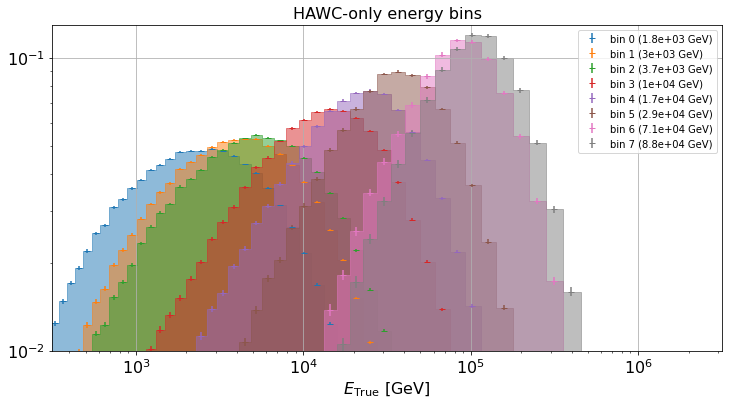

In [565]:
import scipy as sp
import scipy.stats 
from scipy.stats import norm as scinorm
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

#bins = 100
bins = np.logspace(np.log10(1.8),np.log10(6.5),70)
#bins = np.linspace(0,4,100)
energy_bins = np.array([2.7, 4., 5.5, 12.2,18.6,30.3,72.8,100])*1e3
print(72.8+np.power(10,.5))
print(np.power(10, np.log10(72.8) + .5))


xlabel = r'$E_\mathrm{True}$ [GeV]'
fig= plt.figure(figsize=(12,6))
ax = plt.subplot(111)
for i in range(len(energy_bins)):

    fhit = dataset["mc"]["nHit"]/dataset["mc"]["nChAvail"] 
    energy = dataset["mc"]["protonlheEnergy"]-9#+.055
    zenith = dataset["mc"]["zenithAngle"]
    weights = dataset["mc"]["weights"]
    pinc = dataset["mc"]["PINC"]
    cxpe40x = dataset["mc"]["CxPE40XnCh"]
    mcenergy = dataset["mc"]["logEnergy"]#-9
 
    cuts = np.logical_and(zenith < np.radians(70),zenith > 0)
    cuts = np.logical_and(cuts, dataset["mc"]["corsikaParticleId"]!=1 )
    cuts = np.logical_and(cuts, energy>(np.log10(energy_bins[i])-.1))
    cuts = np.logical_and(cuts, energy<(np.log10(energy_bins[i])+.5))
    cuts = np.logical_and(cuts, cxpe40x>40)
    cuts = np.logical_and(cuts, fhit>=0.05)

    hn, hbins = np.histogram(mcenergy[cuts], bins=bins, weights=weights[cuts])
    norm = hn.sum()
    

    q16,q50,q84 = weighted_quantile(mcenergy[cuts], [.16,.5,.84], sample_weight=weights[cuts])
    print("E_med=%0.3g (-%0.3g, +%0.3g)"%tuple(np.power(10,[q50,q16,q84])*1e-3))
    
    # calculate the errors: sqrt(\sum w^2)
    en, ebins = np.histogram(mcenergy[cuts], bins=bins, weights=np.power(weights[cuts],2))  
    hn = np.nan_to_num(hn)
    en = np.nan_to_num(en)
    tm = plt.errorbar(np.power(10,ebins[1:]),hn/norm, yerr=np.sqrt(en)/norm,fmt="_", label="bin %s (%0.2g GeV)"%(i,np.power(10,q50)))
    color = tm[0].get_color()

    
    ax.fill_between(np.power(10,ebins[1:]), 1e-6, hn/norm, step='mid', color=color,alpha=0.5)
    maxbin = max(hn/norm)
    
    ecut = energy_bins[i]
       
ax.grid()

plt.xlabel(xlabel, fontsize=16)
plt.title('HAWC-only energy bins', fontsize=16)
plt.xscale("log")


plt.legend()
plt.ylim(1e-2,1.3e-1)
plt.xlim(10**2.5,10**6.5)
plt.yscale("log")
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
     item.set_fontsize(16)

fig.savefig("energybins_hw.pdf", dpi=100)
plt.show()